In [4]:
#importing all lib and dependencies
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import pandas as pd


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.cryptocurrencies import CryptoCurrencies
print("everything loaded")


everything loaded


In [16]:
#api key: V9Z2AN6WG17PDHZU

config = {
    "alpha_vantage": {
        "key": "V9Z2AN6WG17PDHZU",
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "alpha_vantage_crypto": {
        "key": "V9Z2AN6WG17PDHZU",
        "symbol": "BTC",
        "market": "USD",  #"CNY"
        "key_close": "4b.close (USD)",
    },
    
    "data": {
        "window_size": 20,
        "tran_split_size": 0.80,
    },
    "model": {
        "input_size": 1, #using only one feature: the close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "model_mine":{
        "input_size": 5 #features used: open, close, high, low, volume
        "num_lstm_layers": 3,
        "lstm_size": 128,
        "dropout": 0.05
    },
    "training": {
        "device": "cuda", #cuda or cpu
        "batch_size": 64,
        "num_epoch": 1000,
        "learning_rate": 0.0001,
        "scheduler_step_size": 40,
    }
}

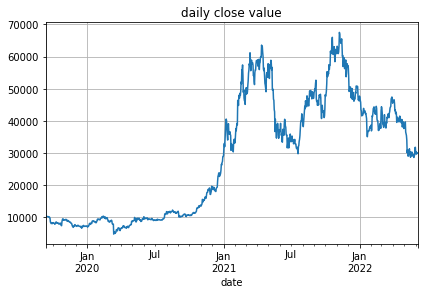

In [18]:
def plot_data(pd_data):
    pd_data.plot()
    plt.tight_layout()
    plt.title("daily close value")
    plt.grid()
    plt.show()

plot_data(data["4b. close (USD)"])

In [44]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"], output_format = "pandas")
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize = 'full')
    return data

def download_crypto_data(config):
    cc = CryptoCurrencies(key = config["alpha_vantage_crypto"]["key"], output_format = 'pandas')
    data, meta_data = cc.get_digital_currency_daily(symbol = config["alpha_vantage_crypto"]["symbol"], market = config["alpha_vantage_crypto"]["market"])
    return data


In [59]:
stock_data = download_data(config)
crypto_data = download_crypto_data(config)
#stock_data["4. close"].plot()
#crypto_data["4b. close (USD)"].plot()

In [65]:
#normalization:
#mean normalization:

def norm_dataframe_mean(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

#min-max normalization:   
#normalized_df=(df-df.min())/(df.max()-df.min())

def norm_dataframe_minmax(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

#norm_dataframe_minmax(stock_data)["4. close"].plot()
#norm_dataframe_mean(stock_data)["4. close"].plot()


stock_data_normed = norm_dataframe_mean(stock_data)
crypto_data_normed = norm_dataframe_mean(crypto_data)

In [69]:
#check this: https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/

#data preparation
#    x: the last 20 days price              shape: [length_of_data, 20]
#    Y: the future price (21st day price)   shape: [length_of_data, ]
#    
#    train-test split. done by scipy or pandas. 
#    ratio: train : validation : test  =  7:2:1

stock_data_normed["6. close MA"] = stock_data_normed["4. close"].rolling(window=20).mean() 


In [72]:
stock_data_normed["6. close MA"].shape

(5685,)